In [1]:
import os
import shutil

SOURCE_BASE = "/kaggle/input/plant-village-dataset-updated"

DEST_BASE = "/kaggle/working/plant-village-merged"

plants = [
    "Apple",
    "Bell Pepper",
    "Cherry",
    "Corn (Maize)",
    "Grape",
    "Peach",
    "Potato",
    "Strawberry",
    "Tomato"
]

splits = ["Train", "Val", "Test"]


for split in splits:
    os.makedirs(os.path.join(DEST_BASE, split), exist_ok=True)


for plant in plants:
    for split in splits:
        plant_split_dir = os.path.join(SOURCE_BASE, plant, split)
        if not os.path.isdir(plant_split_dir):
            continue
        
        # Each disease folder inside Apple/Train, Apple/Val, etc.
        for disease in os.listdir(plant_split_dir):
            disease_folder = os.path.join(plant_split_dir, disease)
            if not os.path.isdir(disease_folder):
                continue
            
            # Make a combined class name to avoid collisions:
            # e.g., "Apple_Apple Scab"
            combined_class_name = f"{plant}_{disease}"
            
            # Create the destination subfolder
            dest_class_dir = os.path.join(DEST_BASE, split, combined_class_name)
            os.makedirs(dest_class_dir, exist_ok=True)
            
            # Copy all images
            for img_name in os.listdir(disease_folder):
                src_path = os.path.join(disease_folder, img_name)

                if os.path.isdir(src_path):
                    continue
                
                dst_path = os.path.join(dest_class_dir, img_name)
                # Copy or move the image (copy2 preserves metadata)
                shutil.copy2(src_path, dst_path)

print("Merging complete!")


Merging complete!


In [39]:
import os

def count_images_in_folder(folder_path):
    """Count the number of image files in a folder (recursively)."""
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(valid_extensions):
                count += 1
    return count

# Paths to your flattened dataset splits
train_path = '/kaggle/working/plant-village-merged/Train'
val_path   = '/kaggle/working/plant-village-merged/Val'
test_path  = '/kaggle/working/plant-village-merged/Test'

# Count images in each split
train_count = count_images_in_folder(train_path)
val_count   = count_images_in_folder(val_path)
test_count  = count_images_in_folder(test_path)

print("Total training images:  ", train_count)
print("Total validation images:", val_count)
print("Total testing images:   ", test_count)


Total training images:   53690
Total validation images: 12067
Total testing images:    1354


In [6]:
import os
import numpy as np
import tensorflow as tf
from collections import Counter

# -----------------------------
# DATASET SETUP
# -----------------------------
dataset_path = '/kaggle/working/plant-village-merged'
train_path = os.path.join(dataset_path, "Train")
val_path   = os.path.join(dataset_path, "Val")
test_path  = os.path.join(dataset_path, "Test")

# Function to get file paths and labels from the directory structure.
def get_file_paths_and_labels(train_path):
    classes = sorted(os.listdir(train_path))
    file_paths = []
    labels = []
    for idx, cls in enumerate(classes):
        class_dir = os.path.join(train_path, cls)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                if os.path.isfile(os.path.join(class_dir, file)):
                    file_paths.append(os.path.join(class_dir, file))
                    labels.append(idx)
    return file_paths, labels, classes

# Get the file paths and labels
file_paths, labels, classes = get_file_paths_and_labels(train_path)

# Check counts per class (using numeric labels)
counts = Counter(labels)
print("Original class counts:")
for cls_idx, count in counts.items():
    print(f"{classes[cls_idx]}: {count} images")

# Determine the maximum number of images among all classes
max_count = max(counts.values())

# Oversample: for each class, randomly choose additional indices to match the max count.
balanced_file_paths = list(file_paths)
balanced_labels = list(labels)

for cls in range(len(classes)):
    # Get indices for the current class
    cls_indices = [i for i, label in enumerate(labels) if label == cls]
    current_count = counts[cls]
    
    # Number of samples to add
    n_to_add = max_count - current_count
    if n_to_add > 0:
        # Randomly sample indices with replacement from current indices
        oversampled_indices = np.random.choice(cls_indices, size=n_to_add, replace=True)
        balanced_file_paths.extend([file_paths[i] for i in oversampled_indices])
        balanced_labels.extend([labels[i] for i in oversampled_indices])

# Verify new counts
balanced_counts = Counter(balanced_labels)
print("\nBalanced class counts:")
for cls_idx, count in balanced_counts.items():
    print(f"{classes[cls_idx]}: {count} images")

# Create a TensorFlow dataset from the balanced file paths and labels.
def load_and_preprocess_image(path, label, img_size=(128, 128)):
    # Read image file
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    # Normalize the image to [0,1]
    image = image / 255.0
    return image, label

balanced_ds = tf.data.Dataset.from_tensor_slices((balanced_file_paths, balanced_labels))
balanced_ds = balanced_ds.shuffle(buffer_size=len(balanced_file_paths))
balanced_ds = balanced_ds.map(lambda path, label: load_and_preprocess_image(path, label),
                              num_parallel_calls=tf.data.AUTOTUNE)
balanced_ds = balanced_ds.batch(32).prefetch(tf.data.AUTOTUNE)


# Path where the new balanced dataset will be saved
balanced_dataset_path = "/kaggle/working/balanced-plant-village"

# Create the new dataset directory
os.makedirs(balanced_dataset_path, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(balanced_dataset_path, cls), exist_ok=True)

# Copy original images to new dataset
for src_path, label in zip(file_paths, labels):
    class_name = classes[label]
    dst_path = os.path.join(balanced_dataset_path, class_name, os.path.basename(src_path))
    shutil.copy(src_path, dst_path)

# Oversampling: copy additional images to balance dataset
for cls in range(len(classes)):
    cls_indices = [i for i, label in enumerate(labels) if label == cls]
    current_count = counts[cls]
    n_to_add = max_count - current_count
    
    if n_to_add > 0:
        oversampled_indices = np.random.choice(cls_indices, size=n_to_add, replace=True)
        for idx in oversampled_indices:
            src_path = file_paths[idx]
            class_name = classes[cls]
            filename = f"aug_{np.random.randint(10000)}_{os.path.basename(src_path)}"  # Rename to avoid conflicts
            dst_path = os.path.join(balanced_dataset_path, class_name, filename)
            shutil.copy(src_path, dst_path)

print(f"Balanced dataset saved at: {balanced_dataset_path}")



Original class counts:
Apple_Apple Scab: 2016 images
Apple_Black Rot: 1987 images
Apple_Cedar Apple Rust: 1760 images
Apple_Healthy: 2008 images
Bell Pepper_Bacterial Spot: 1913 images
Bell Pepper_Healthy: 1988 images
Cherry_Healthy: 1826 images
Cherry_Powdery Mildew: 1683 images
Corn (Maize)_Cercospora Leaf Spot: 1642 images
Corn (Maize)_Common Rust : 1907 images
Corn (Maize)_Healthy: 1859 images
Corn (Maize)_Northern Leaf Blight: 1908 images
Grape_Black Rot: 1888 images
Grape_Esca (Black Measles): 1920 images
Grape_Healthy: 1692 images
Grape_Leaf Blight: 1722 images
Peach_Bacterial Spot: 1838 images
Peach_Healthy: 1728 images
Potato_Early Blight: 1939 images
Potato_Healthy: 1824 images
Potato_Late Blight: 1939 images
Strawberry_Healthy: 1824 images
Strawberry_Leaf Scorch: 1774 images
Tomato_Bacterial Spot: 1702 images
Tomato_Early Blight: 1920 images
Tomato_Healthy: 1926 images
Tomato_Late Blight: 1851 images
Tomato_Septoria Leaf Spot: 1745 images
Tomato_Yellow Leaf Curl Virus: 1961 

In [7]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# -----------------------------
# 1. DATASET SETUP
# -----------------------------
dataset_path = '/kaggle/working/plant-village-merged'
train_path = '/kaggle/working/balanced-plant-village'
val_path   = os.path.join(dataset_path, "Val")
test_path  = os.path.join(dataset_path, "Test")

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_path, target_size=(128, 128), batch_size=32, class_mode='categorical'
)
val_data = val_test_datagen.flow_from_directory(
    val_path, target_size=(128, 128), batch_size=32, class_mode='categorical'
)
test_data = val_test_datagen.flow_from_directory(
    test_path, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

num_classes = train_data.num_classes

# -----------------------------
# 2. TEACHER MODELS (Ensemble)
# -----------------------------
PROJ_DIM = 1280  # Target feature dimension

def build_teacher_model(base_fn, input_shape=(128,128,3), num_classes=num_classes, proj_dim=PROJ_DIM):
    base = base_fn(input_shape=input_shape, include_top=False, pooling='avg')
    features = base.output  # raw features
    proj_features = layers.Dense(proj_dim, activation='relu', name='proj_features')(features)
    predictions = layers.Dense(num_classes, activation='softmax')(proj_features)
    model = Model(inputs=base.input, outputs=[proj_features, predictions])
    return model

teacher1 = build_teacher_model(tf.keras.applications.MobileNetV3Large)
teacher2 = build_teacher_model(tf.keras.applications.EfficientNetB1)
teacher3 = build_teacher_model(tf.keras.applications.MobileNetV2)

for teacher in [teacher1, teacher2, teacher3]:
    teacher.trainable = False

# -----------------------------
# 3. STUDENT MODEL (Compact & Enhanced)
# -----------------------------
def squeeze_excite_block(inputs, ratio=16):
    channel_axis = -1
    filters = inputs.shape[channel_axis]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    return layers.multiply([inputs, se])

def build_student_model(input_shape=(128,128,3), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # First block using SeparableConv2D with proper regularizers
    x = layers.SeparableConv2D(64, (3,3), padding='same', activation='relu',
                               depthwise_regularizer=regularizers.l2(1e-4),
                               pointwise_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = squeeze_excite_block(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # Second block: additional convolution block for enhanced capacity
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Final block
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    student_features = layers.GlobalAveragePooling2D()(x)  # Output shape: (None, 256)
    predictions = layers.Dense(num_classes, activation='softmax')(student_features)
    model = Model(inputs=inputs, outputs=[student_features, predictions])
    return model

student = build_student_model()

# -----------------------------
# 4. DISTILLATION SETUP WITH MULTI-LEVEL DISTILLATION
# -----------------------------
class MultiLevelDistiller(tf.keras.Model):
    def __init__(self, student, teacher_models, temperature=5.0, alpha=0.5, beta=0.5, proj_dim=PROJ_DIM):
        super(MultiLevelDistiller, self).__init__()
        self.student = student
        self.teacher_models = teacher_models
        self.temperature = temperature
        self.alpha = alpha  # weight for hard-label loss
        self.beta = beta    # weight for feature alignment loss
        # Apply label smoothing to help prevent overconfidence
        self.ce_loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
        self.kl_loss_fn = tf.keras.losses.KLDivergence()
        self.feature_loss_fn = tf.keras.losses.MeanSquaredError()
        self.student_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        # Learnable teacher weights via add_weight
        self.teacher_weights = self.add_weight(
            name="teacher_weights", shape=(len(teacher_models),),
            initializer=tf.keras.initializers.Constant(1.0), trainable=True, dtype=tf.float32
        )
        # Projection layer for student features to match teacher dimension
        self.student_proj = layers.Dense(proj_dim, activation='relu', name='student_proj')
    
    def compile(self, optimizer):
        super(MultiLevelDistiller, self).compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y_true = data

        teacher_features_list = []
        teacher_preds_list = []
        for teacher in self.teacher_models:
            feat, pred = teacher(x, training=False)
            teacher_features_list.append(feat)
            teacher_preds_list.append(pred)
        
        norm_weights = tf.nn.softmax(self.teacher_weights)
        
        fused_teacher_pred = tf.reduce_sum(
            tf.stack([w * p for w, p in zip(tf.unstack(norm_weights), teacher_preds_list)], axis=0),
            axis=0)
        fused_teacher_feat = tf.reduce_sum(
            tf.stack([w * f for w, f in zip(tf.unstack(norm_weights), teacher_features_list)], axis=0),
            axis=0)
        
        with tf.GradientTape() as tape:
            student_feat, student_pred = self.student(x, training=True)
            # Project student features to match teacher dimension
            student_feat_proj = self.student_proj(student_feat)
            
            loss_ce = self.ce_loss_fn(y_true, student_pred)
            student_soft = tf.nn.softmax(student_pred / self.temperature)
            teacher_soft = tf.nn.softmax(fused_teacher_pred / self.temperature)
            loss_kd = self.kl_loss_fn(teacher_soft, student_soft) * (self.temperature ** 2)
            loss_feat = self.feature_loss_fn(fused_teacher_feat, student_feat_proj)
            
            total_loss = self.alpha * loss_ce + (1 - self.alpha) * (loss_kd + self.beta * loss_feat)
        
        trainable_vars = (self.student.trainable_variables +
                          self.student_proj.trainable_variables +
                          [self.teacher_weights])
        grads = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        
        self.student_acc_metric.update_state(y_true, student_pred)
        return {
            "loss": total_loss,
            "ce_loss": loss_ce,
            "kd_loss": loss_kd,
            "feat_loss": loss_feat,
            "accuracy": self.student_acc_metric.result()
        }
    
    def test_step(self, data):
        x, y_true = data
        _, student_pred = self.student(x, training=False)
        loss = self.ce_loss_fn(y_true, student_pred)
        self.student_acc_metric.update_state(y_true, student_pred)
        return {"loss": loss, "accuracy": self.student_acc_metric.result()}

distiller = MultiLevelDistiller(
    student=student,
    teacher_models=[teacher1, teacher2, teacher3],
    temperature=5.0,
    alpha=0.5,
    beta=0.5,
    proj_dim=PROJ_DIM
)

# -----------------------------
# Using AdamW with Cosine Decay LR schedule
# -----------------------------
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    alpha=1e-6
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
distiller.compile(optimizer=optimizer)

# -----------------------------
# 5. TRAINING & EVALUATION WITH CALLBACKS
# -----------------------------
# Keep ReduceLROnPlateau for additional LR adjustments if desired
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,           
    verbose=1, 
    restore_best_weights=True
)

# Train for 50 epochs with callbacks
distiller.fit(
    train_data, 
    validation_data=val_data, 
    epochs=50, 
    callbacks=[lr_scheduler, early_stopping]
)

results = distiller.evaluate(test_data)
print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(results[0], results[1]))

Found 58464 images belonging to 29 classes.
Found 12067 images belonging to 29 classes.
Found 1354 images belonging to 29 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['teacher_weights'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1827/1827 ━━━━━━━━━━━━━━━━━━━━ 384s 191ms/step - accuracy: 0.6417 - ce_loss: 1.3293 - feat_loss: 0.0221 - kd_loss: 0.0080 - loss: 0.6741 - val_accuracy: 0.7915 - val_loss: 1.4940 - learning_rate: 9.1988e-04
Epoch 2/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 343s 187ms/step - accuracy: 0.9284 - ce_loss: 0.9323 - feat_loss: 0.0158 - kd_loss: 0.0112 - loss: 0.4757 - val_accuracy: 0.8497 - val_loss: 0.8172 - learning_rate: 7.0518e-04
Epoch 3/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 343s 187ms/step - accuracy: 0.9586 - ce_loss: 0.8565 - feat_loss: 0.0151 - kd_loss: 0.0120 - loss: 0.4380 - val_accuracy: 0.9158 - val_loss: 0.7479 - learning_rate: 4.2473e-04
Epoch 4/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 341s 186ms/step - accuracy: 0.9736 - ce_loss: 0.8136 - feat_loss: 0.0147 - kd_loss: 0.0124 - loss: 0.4167 - val_accuracy: 0.9615 - val_loss: 0.7558 - learning_rate: 1.6840e-04
Epoch 5/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 344s 188ms/step - accuracy: 0.9816 - ce_loss: 0.7903 - feat_loss: 0.0144 - kd_loss: 0.0126 - loss

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Test Accuracy: 0.9808
Classification Report:
                                    precision    recall  f1-score   support

                 Apple_Apple Scab       1.00      1.00      1.00        51
                  Apple_Black Rot       1.00      1.00      1.00        50
           Apple_Cedar Apple Rust       1.00      1.00      1.00        44
                    Apple_Healthy       0.94      1.00      0.97        51
       Bell Pepper_Bacterial Spot       1.00      0.98      0.99        48
              Bell Pepper_Healthy       0.96      0.98      0.97        50
                   Cherry_Healthy       0.98      1.00      0.99        46
            Cherry_Powdery Mildew       1.00      1.00      1.00        43
Corn (Maize)_Cercospora Leaf Spot       0.95      0.98      0.96        41
        Corn (Maize)_Common Rust        0.98      1.00      0.99        48
             Corn (Maize)_Healthy       1.00      1.00      1.00        47
Corn (Maize)_

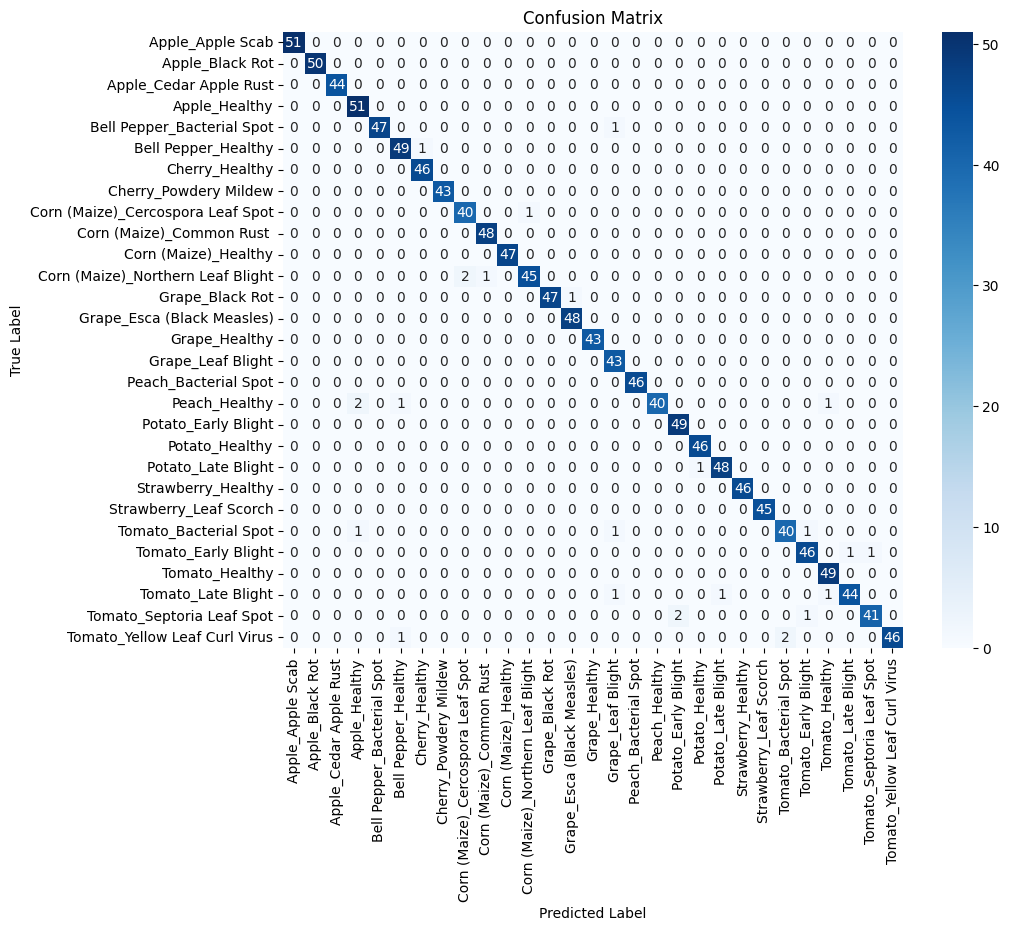

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluate the student model on the test set
# Note: student.predict returns [features, predictions]
features, predictions = student.predict(test_data, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test generator
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# Print overall test accuracy
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print("Test Accuracy: {:.4f}".format(accuracy))

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

# Compute and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# After training is complete, save the student model
student.save('/kaggle/working/student_model_final.h5')

In [38]:
loaded_student = tf.keras.models.load_model('/kaggle/working/student_model_final.h5')

# -----------------------------
# 6. PREDICTION ON A NEW IMAGE
# -----------------------------
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(128,128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

def predict_disease(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    
    # Get predictions; our model returns (features, predictions)
    _, preds = model(img_array, training=False)
    
    # Determine predicted class index
    pred_idx = np.argmax(preds, axis=1)[0]
    
    # Invert class_indices dictionary to map index to class label
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_label = inv_class_indices[pred_idx]
    
    print(f"Predicted Disease: {predicted_label}")
    return predicted_label

# Example usage:
new_image_path = '/kaggle/input/apple-disease-dataset/datasets/test/apple_scab/023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_90deg.JPG'
predicted_disease = predict_disease(loaded_student, new_image_path, train_data.class_indices)


Predicted Disease: Apple_Apple Scab


In [42]:
# Example usage:
new_image_path = '/kaggle/input/leaf-disease-dataset-combination/image data/validation/grape/esca (black measles)/011bb69d-fb9c-4fb9-b8cc-031e91270ec2___FAM_B.Msls 4288.JPG'
predicted_disease = predict_disease(loaded_student, new_image_path, train_data.class_indices)


Predicted Disease: Grape_Esca (Black Measles)


In [45]:
# Example usage:
new_image_path = '/kaggle/input/leaf-disease-dataset-combination/image data/validation/pepper, bell/bacterial spot/03bb7042-3fd5-42e1-aa2c-d51d6843704c___JR_B.Spot 8925.JPG'
predicted_disease = predict_disease(loaded_student, new_image_path, train_data.class_indices)


Predicted Disease: Bell Pepper_Bacterial Spot


Epoch 1/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 341s 186ms/step - accuracy: 0.9838 - ce_loss: 0.7830 - feat_loss: 0.0143 - kd_loss: 0.0127 - loss: 0.4014 - val_accuracy: 0.9758 - val_loss: 0.8306 - learning_rate: 1.0000e-09
Epoch 2/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 341s 186ms/step - accuracy: 0.9850 - ce_loss: 0.7847 - feat_loss: 0.0143 - kd_loss: 0.0126 - loss: 0.4022 - val_accuracy: 0.9752 - val_loss: 0.7291 - learning_rate: 1.0000e-09
Epoch 3/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 341s 186ms/step - accuracy: 0.9836 - ce_loss: 0.7837 - feat_loss: 0.0143 - kd_loss: 0.0126 - loss: 0.4017 - val_accuracy: 0.9745 - val_loss: 0.7415 - learning_rate: 1.0000e-09
Epoch 4/50
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 343s 187ms/step - accuracy: 0.9837 - ce_loss: 0.7831 - feat_loss: 0.0143 - kd_loss: 0.0127 - loss: 0.4015 - val_accuracy: 0.9751 - val_loss: 0.7697 - learning_rate: 1.0000e-09
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


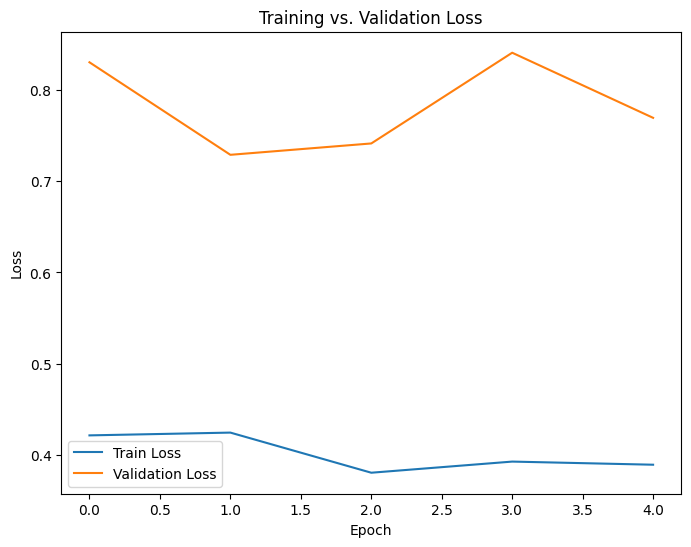

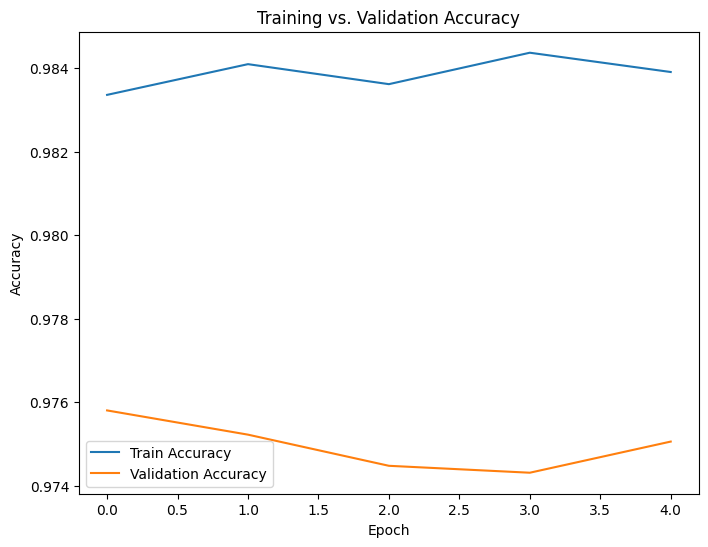

In [50]:
import matplotlib.pyplot as plt

history = distiller.fit(
    train_data, 
    validation_data=val_data, 
    epochs=50, 
    callbacks=[lr_scheduler, early_stopping]
)

# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
